## Import libraries

In [1]:
# !pip install tensorly

import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.decomposition import tensor_train
from math import ceil
from tensorly import tt_to_tensor
from tensorly.decomposition import matrix_product_state
import torch.nn.init as init

In [2]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50;
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
#from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version: 1.13.1
Torchvision Version: 0.14.1
GPU is available? True


## train data processing

In [3]:
df_train_1 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_training.csv')
df_train_2 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_validation.csv')
# concat train and validation into train. we don't need validation set
df_train = df_train_1.append(df_train_2).reset_index(drop=True)

# undersampling for "negative" samples
negative_df = df_train[df_train['label'] == 'Negative']
positive_df = df_train[df_train['label'] == 'Positive']

# Get number of "positive" samples
num_positive = len(positive_df)

# take the same number of "negative" samples as there are "positive" samples
balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

df_train_balanced = pd.concat([positive_df, balanced_negative_df])
print(df_train_balanced['label'].value_counts())

Positive    4057
Negative    4057
Name: label, dtype: int64


In [4]:
pd_X_train = df_train_balanced.iloc[:, 5:]
pd_y_train = df_train_balanced.iloc[:, 0]

N = len(pd_X_train)
K = 2

pd_X_train = pd_X_train.values
X_train = torch.tensor(pd_X_train, dtype=dtype, device=device)
X_train = torch.t(X_train)

# scaler = MinMaxScaler()
# x = pd_X_train.values
# x_scaled = scaler.fit_transform(x)
# X_train = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_train = torch.t(X_train)

# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_train.values)
y_train=torch.tensor(y, dtype=torch.long, device=device)
y_train = torch.flatten(y_train)

y_one_hot = torch.zeros(N, K, device=device).scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

print(list(encoder.classes_))

['Negative', 'Positive']


## test data processing

In [5]:
df_test = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_testing.csv')

# Undersampling for "negative" samples
#negative_df = df_test[df_test['label'] == 'Negative']
#positive_df = df_test[df_test['label'] == 'Positive']

# Get number of "positive" samples
#num_positive = len(positive_df)

# Take the same number of "negative" samples as there are "positive" samples
#balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

#df_test_balanced = pd.concat([positive_df, balanced_negative_df])
#print(df_test_balanced['label'].value_counts())

In [6]:
pd_X_test = df_test.iloc[:, 5:]
pd_y_test = df_test.iloc[:, 0]

N_test = len(pd_X_test)
K = 2

pd_X_test = pd_X_test.values
X_test = torch.tensor(pd_X_test, dtype=dtype, device=device)
X_test = torch.t(X_test)
# x = pd_X_test.values
# x_scaled = scaler.transform(x)  # only transform x, don't fit the scaler again
# X_test = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_test = torch.t(X_test)


# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_test.values)
y_test=torch.tensor(y, dtype=torch.long, device=device)
y_test = torch.flatten(y_test)

y_test_one_hot = torch.zeros(N_test, K, device=device).scatter_(1, y_test.unsqueeze(1), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

In [7]:
print(df_test['label'].value_counts())

Negative    43411
Positive     1278
Name: label, dtype: int64


## Main algorithm

### Define functions for updating blocks

In [8]:
# def updateMask(W, sparsity):
#     torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy()
#     Mask
#     Wsparse
#     return Mask, Wsparse

# Wsquare = torch.square(W3)
# Threshold = torch.quantile(torch.reshape(Wsquare, (-1,)), 0.5, interpolation='linear')
# Wsparse = W3
# Wsparse[Wsquare < Threshold] =  0

# Wsparse

In [9]:
def updateV(U1,U2,W,b,rho,gamma):
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [10]:
def updateWb_org(U, V, W, b, alpha, rho):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [11]:
def updateWb(U, V, W, b, W_tensor_rec, alpha, rho,tau):
    W_tensor_rec = torch.as_tensor(W_tensor_rec,device=device).float()
    W_tensor2matrix = W_tensor_rec.reshape(W.shape)
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [12]:
def updateWbsparse(U, V, W, b,  W_tensor2matrix, alpha, rho,tau):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [13]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Effective Sparsity

In [14]:
def process_weights(W1, W2, W3):
    # Clone the tensors to keep the originals unchanged
    W1, W2, W3 = W1.clone(), W2.clone(), W3.clone()

    while True:
        # Store a copy of the current weights
        old_W1, old_W2, old_W3 = W1.clone(), W2.clone(), W3.clone()

        # Check all rows of W1
        # If all values in a row of W1 are 0, set corresponding column in W2 to 0
        zero_rows_W1 = torch.all(W1 == 0, dim=1)
        W2[:, zero_rows_W1] = 0

        # Check all columns of W2
        # If all values in a column of W2 are 0, set corresponding row in W1 to 0
        zero_cols_W2 = torch.all(W2 == 0, dim=0)
        W1[zero_cols_W2, :] = 0

        # Check all rows of W2
        # If all values in a row of W2 are 0, set corresponding column in W3 to 0
        zero_rows_W2 = torch.all(W2 == 0, dim=1)
        W3[:, zero_rows_W2] = 0

        # Check if matrices are unchanged
        if torch.equal(W1, old_W1) and torch.equal(W2, old_W2) and torch.equal(W3, old_W3):
            break

    return W1, W2, W3

### Parameter initialization

In [15]:
#df = pd.DataFrame()
#df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')

niter = 1000
sparsity = 0.9

tau = 200
alpha = 1
rho = 1
gamma = 100

        

# Do something with these parameters
print(sparsity, tau, gamma, rho, alpha)

loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)
bacc_train = np.empty(niter)
bacc_test = np.empty(niter)
true_sparsity = np.empty(niter)
effective_sparsity = np.empty(niter)

results = torch.zeros(1, 9, niter)

for Out_iter in range(1):
    rank_initial = 700
    seed = 10 + 10*Out_iter
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)

    d0 = 40
    d1 =  300
    d2 =  100
    d3 = K # Layers: input + 2 hidden + output

    W1 = 0.2*init.xavier_normal_(torch.empty(d1, d0, device=device,dtype=dtype), gain=1.0)
    b1 = 0*torch.ones(d1, 1, dtype=torch.float64,device=device)
    W1square = torch.square(W1)
    Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
    W1sparse = W1
    W1sparse[W1square < Threshold] =  0

    W2 = 0.2*init.xavier_normal_(torch.empty(d2, d1, device=device,dtype=dtype), gain=1.0)
    b2 = 0*torch.ones(d2, 1, dtype=torch.float64,device=device)
    W2square = torch.square(W2)
    Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
    W2sparse = W2
    W2sparse[W2square < Threshold] =  0


    W3 = 0.2*init.xavier_normal_(torch.empty(d3, d2, device=device,dtype=dtype), gain=1.0)
    b3 = 0*torch.ones(d3, 1, dtype=torch.float64,device=device)
    # W3square = torch.square(W3)
    # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
    # W3sparse = W3
    # W3sparse[W3square < Threshold] =  0


    U1 = torch.addmm(b1.repeat(1, N), W1, X_train)
    V1 = nn.ReLU()(U1)
    U2 = torch.addmm(b2.repeat(1, N), W2, V1)
    V2 = nn.ReLU()(U2)
    U3 = torch.addmm(b3.repeat(1, N), W3, V2)
    V3 = U3
    # U4 = torch.addmm(b4.repeat(1, N), W4, V3)
    # V4 = U4


    print('Train on', N, 'samples, validate on', N_test, 'samples')

    for k in range(niter):

        start = time.time()

        # update V4
        V3 = (y_one_hot + gamma*U3 + alpha*V3)/(1 + gamma + alpha)

        # update U4
        U3 = (gamma*V3 + rho*(torch.mm(W3,V2) + b3.repeat(1,N)))/(gamma + rho)

        # update W4 and b4
        W3, b3 = updateWb_org(U3,V2,W3,b3, alpha,rho)
        # W3square = torch.square(W3)
        # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
        # W3sparse = W3
        # W3sparse[W3square < Threshold] =  0
        # update V2
        V2 = updateV(U2,U3,W3,b3,rho,gamma)

        # update U2
        U2 = relu_prox(V2,(rho*torch.addmm(b2.repeat(1,N), W2, V1) + alpha*U2)/(rho + alpha),(rho + alpha)/gamma,d2,N)

        # update W2 and b2

        W2, b2 = updateWbsparse(U2,V1,W2,b2,W2sparse, alpha,rho,tau)
        W2square = torch.square(W2)
        Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
        W2sparse = W2
        W2sparse[W2square < Threshold] =  0

        # update V1
        V1 = updateV(U1,U2,W2,b2,rho,gamma)

        # update U1
        U1 = relu_prox(V1,(rho*torch.addmm(b1.repeat(1,N), W1, X_train) + alpha*U1)/(rho + alpha),(rho + alpha)/gamma,d1,N)

        # update W1 and b1
        W1, b1 = updateWbsparse(U1,X_train,W1,b1,W1sparse, alpha,rho,tau)
        W1square = torch.square(W1)
        Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
        W1sparse = W1
        W1sparse[W1square < Threshold] =  0

        a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1sparse, X_train)).double()
        a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N),  W2sparse, a1_train)).double()
        pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

        a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1sparse, X_test)).double()
        a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test),  W2sparse, a1_test)).double()
        pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)


        loss1[k] = gamma/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
        loss2[k] = loss1[k] + rho/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1sparse, X_train),U1,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N),  W2sparse, V1),U2,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V2,nn.ReLU()(U2),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V3,U3,2),2).cpu().numpy() \
        + tau/2*torch.pow(torch.dist(W1,W1sparse,2),2).cpu().numpy()\
        + tau/2*torch.pow(torch.dist(W2,W2sparse,2),2).cpu().numpy()\
        # + tau/2*torch.pow(torch.dist(W3,W3sparse,2),2).cpu().numpy()

        # compute training accuracy
        correct_train = pred == y_train
        accuracy_train[k] = np.mean(correct_train.cpu().numpy())

        # compute validation accuracy
        correct_test = pred_test == y_test
        accuracy_test[k] = np.mean(correct_test.cpu().numpy())


        pred_train_np = pred.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        pred_test_np = pred_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        bacc_train[k] = balanced_accuracy_score(y_train_np, pred_train_np)
        bacc_test[k] = balanced_accuracy_score(y_test_np, pred_test_np)

        # compute training time
        stop = time.time()
        duration = stop - start
        time1[k] = duration

        # sparsity
        num_zeros_W1 = torch.sum(W1 == 0).item()
        num_zeros_W2 = torch.sum(W2 == 0).item()
        num_zeros_W3 = torch.sum(W3 == 0).item()
        total_zeros_old = num_zeros_W1 + num_zeros_W2 + num_zeros_W3
        total_weights = d0*d1+d1*d2+d2*d3
        true_sparsity[k] = total_zeros_old / total_weights

        new_W1, new_W2, new_W3 = process_weights(W1, W2, W3)
        num_zeros_W1_new = torch.sum(new_W1 == 0).item()
        num_zeros_W2_new = torch.sum(new_W2 == 0).item()
        num_zeros_W3_new = torch.sum(new_W3 == 0).item()
        total_zeros = num_zeros_W1_new + num_zeros_W2_new + num_zeros_W3_new
        total_weights = d0*d1+d1*d2+d2*d3
        effective_sparsity[k] = total_zeros / total_weights


        # print results
        print('Epoch', k + 1, '/', niter, '\n',
              '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k],
              '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k],
              '-', 'bacc_train:', bacc_train[k], '-', 'bacc_test:', bacc_test[k],'-', 'true_sparsity:', true_sparsity[k],
             '-', 'effective_sparsity:', effective_sparsity[k])


    results[Out_iter,0,:] = torch.tensor(loss1)
    results[Out_iter,1,:] = torch.tensor(loss2)
    results[Out_iter,2,:] = torch.tensor(accuracy_train)
    results[Out_iter,3,:] = torch.tensor(accuracy_test)
    results[Out_iter,4,:] = torch.tensor(time1)
    results[Out_iter,5,:] = torch.tensor(bacc_train)
    results[Out_iter,6,:] = torch.tensor(bacc_test)
    results[Out_iter,7,:] = torch.tensor(true_sparsity)
    results[Out_iter,8,:] = torch.tensor(effective_sparsity)

#             df=pd.read_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')
#             new_row = {
#                         'tau': tau, 
#                         'gamma': gamma, 
#                         'rho': rho, 
#                         'alpha': alpha,
#                         'loss1': loss1[niter-1], 
#                         'loss2': loss2[niter-1], 
#                         'accuracy_train': accuracy_train[niter-1],
#                         'accuracy_test': accuracy_test[niter-1], 
#                         'max_accuracy_train': max(accuracy_train),
#                         'max_accuracy_test': max(accuracy_test),
#                         'time': time1[niter-1], 
#                         'BACC_train': bacc_train[niter-1],
#                         'BACC_test': bacc_test[niter-1],
#                         'max_BACC_train': max(bacc_train),
#                         'max_BACC_test': max(bacc_test),
#                         'Sparsity': sparsity,
#                         'seed' : seed
#                     }

#             df=df.append(new_row,ignore_index=True)
#             df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv',index=False)

filename="XavierNormal_" + "niter_"+ str(niter) + "Sparsity_" + str(sparsity) +"tau_" + str(tau) + "gamma_" + str(gamma) + \
                "rho_" + str(rho) + "alpha_" + str(alpha)+ ".mat"
from scipy.io import savemat
%cd /home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/different init/
savemat (filename, {'results': torch.Tensor.numpy(results)})

0.9 200 100 1 1
Train on 8114 samples, validate on 44689 samples
Epoch 1 / 1000 
 - time: 1.0281410217285156 - sq_loss: 398020.93063140084 - tot_loss: 398021.1005922348 - acc: 0.7034754744885383 - val_acc: 0.8725189643983978 - bacc_train: 0.7034754744885383 - bacc_test: 0.7426251537105993 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 2 / 1000 
 - time: 0.05042386054992676 - sq_loss: 390330.6143674188 - tot_loss: 390331.2085192837 - acc: 0.8120532413113137 - val_acc: 0.8616214280919242 - bacc_train: 0.8120532413113137 - bacc_test: 0.8805495650284292 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 3 / 1000 
 - time: 0.040709733963012695 - sq_loss: 382828.29779603943 - tot_loss: 382829.5045031661 - acc: 0.8240078876016761 - val_acc: 0.8628521560115464 - bacc_train: 0.8240078876016761 - bacc_test: 0.8846005114199617 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 4 / 1000 
 - time: 0.

Epoch 29 / 1000 
 - time: 0.026915788650512695 - sq_loss: 231677.6473465661 - tot_loss: 231678.18232924124 - acc: 0.838180921863446 - val_acc: 0.8632996934368636 - bacc_train: 0.838180921863446 - bacc_test: 0.8981210148845178 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 30 / 1000 
 - time: 0.02698493003845215 - sq_loss: 227212.79474584304 - tot_loss: 227213.3358706047 - acc: 0.838180921863446 - val_acc: 0.8633220703081295 - bacc_train: 0.838180921863446 - bacc_test: 0.8981325327025822 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 31 / 1000 
 - time: 0.02686023712158203 - sq_loss: 222833.62965405753 - tot_loss: 222834.1769371734 - acc: 0.838180921863446 - val_acc: 0.8632996934368636 - bacc_train: 0.838180921863446 - bacc_test: 0.8981210148845178 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 32 / 1000 
 - time: 0.027094125747680664 - sq_loss: 218538.54295060274 - tot_loss: 2185

Epoch 57 / 1000 
 - time: 0.03054642677307129 - sq_loss: 134304.07731969707 - tot_loss: 134304.74946549084 - acc: 0.8384274094158245 - val_acc: 0.863881492089776 - bacc_train: 0.8384274094158245 - bacc_test: 0.8988001966428607 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 58 / 1000 
 - time: 0.026925325393676758 - sq_loss: 131713.0342928677 - tot_loss: 131713.70979604896 - acc: 0.8384274094158245 - val_acc: 0.8638591152185101 - bacc_train: 0.8384274094158245 - bacc_test: 0.8987886788247961 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 59 / 1000 
 - time: 0.027013063430786133 - sq_loss: 129171.9396041643 - tot_loss: 129172.61837602341 - acc: 0.8385506531920138 - val_acc: 0.8639038689610419 - bacc_train: 0.8385506531920137 - bacc_test: 0.8988117144609251 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 60 / 1000 
 - time: 0.026860475540161133 - sq_loss: 126679.83284649457 - tot_los

Epoch 87 / 1000 
 - time: 0.0458984375 - sq_loss: 74857.90792343642 - tot_loss: 74858.65084659033 - acc: 0.8408922849396105 - val_acc: 0.8658730336324375 - bacc_train: 0.8408922849396105 - bacc_test: 0.8994455639619405 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 88 / 1000 
 - time: 0.05211687088012695 - sq_loss: 73413.36714925124 - tot_loss: 73414.1117440009 - acc: 0.8410155287157999 - val_acc: 0.8658730336324375 - bacc_train: 0.8410155287157999 - bacc_test: 0.8994455639619405 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 89 / 1000 
 - time: 0.04123353958129883 - sq_loss: 71996.69755581341 - tot_loss: 71997.44381924556 - acc: 0.8408922849396105 - val_acc: 0.8659625411175009 - bacc_train: 0.8408922849396105 - bacc_test: 0.8994916352341986 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 90 / 1000 
 - time: 0.04824399948120117 - sq_loss: 70607.3618399629 - tot_loss: 70608.1097779

Epoch 118 / 1000 
 - time: 0.0272066593170166 - sq_loss: 40916.03237455754 - tot_loss: 40917.15448769459 - acc: 0.8463150110919399 - val_acc: 0.8688939112533286 - bacc_train: 0.8463150110919399 - bacc_test: 0.9002410324233248 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 119 / 1000 
 - time: 0.027217864990234375 - sq_loss: 40126.45816839355 - tot_loss: 40127.6646504043 - acc: 0.8468079861966971 - val_acc: 0.8694533330349751 - bacc_train: 0.8468079861966971 - bacc_test: 0.9005289778749384 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 120 / 1000 
 - time: 0.026926755905151367 - sq_loss: 39352.12186352162 - tot_loss: 39353.43515556931 - acc: 0.8473009613014543 - val_acc: 0.8699680010740898 - bacc_train: 0.8473009613014543 - bacc_test: 0.9000344507130935 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 121 / 1000 
 - time: 0.026849031448364258 - sq_loss: 38592.729493476785 - tot_loss

Epoch 150 / 1000 
 - time: 0.026937007904052734 - sq_loss: 21933.14995739023 - tot_loss: 21934.51731588384 - acc: 0.8492728617204831 - val_acc: 0.8743091140996666 - bacc_train: 0.8492728617204831 - bacc_test: 0.8996108779969625 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 151 / 1000 
 - time: 0.026937246322631836 - sq_loss: 21509.946811541995 - tot_loss: 21511.329960747807 - acc: 0.8489031303919152 - val_acc: 0.8743762447134642 - bacc_train: 0.8489031303919152 - bacc_test: 0.899645431451156 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 152 / 1000 
 - time: 0.026937484741210938 - sq_loss: 21094.911637523695 - tot_loss: 21096.31458953472 - acc: 0.8491496179442938 - val_acc: 0.8744209984559959 - bacc_train: 0.8491496179442939 - bacc_test: 0.8996684670872852 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 153 / 1000 
 - time: 0.026946306228637695 - sq_loss: 20687.88669289742 - tot_

Epoch 182 / 1000 
 - time: 0.026862621307373047 - sq_loss: 11758.49064687938 - tot_loss: 11759.939113802884 - acc: 0.8517377372442692 - val_acc: 0.877441876076887 - bacc_train: 0.8517377372442692 - bacc_test: 0.9016030910146635 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 183 / 1000 
 - time: 0.02714252471923828 - sq_loss: 11531.65310007062 - tot_loss: 11533.136366621515 - acc: 0.8516144934680798 - val_acc: 0.8775090066906845 - bacc_train: 0.8516144934680798 - bacc_test: 0.9016376444688572 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 184 / 1000 
 - time: 0.02687835693359375 - sq_loss: 11309.193306348994 - tot_loss: 11310.725743131365 - acc: 0.8514912496918906 - val_acc: 0.8776432679182796 - bacc_train: 0.8514912496918905 - bacc_test: 0.9017067513772444 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 185 / 1000 
 - time: 0.026974201202392578 - sq_loss: 11091.026751454028 - tot_

Epoch 214 / 1000 
 - time: 0.027187108993530273 - sq_loss: 6304.75532988279 - tot_loss: 6306.551720039826 - acc: 0.8511215183633226 - val_acc: 0.8774866298194186 - bacc_train: 0.8511215183633227 - bacc_test: 0.9020058451394573 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 215 / 1000 
 - time: 0.026876211166381836 - sq_loss: 6183.164249744554 - tot_loss: 6185.007424998332 - acc: 0.8511215183633226 - val_acc: 0.8775313835619504 - bacc_train: 0.8511215183633227 - bacc_test: 0.9020288807755864 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 216 / 1000 
 - time: 0.026910781860351562 - sq_loss: 6063.919541592221 - tot_loss: 6065.828164600595 - acc: 0.8509982745871334 - val_acc: 0.8775090066906845 - bacc_train: 0.8509982745871334 - bacc_test: 0.9023970814461866 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 217 / 1000 
 - time: 0.02683568000793457 - sq_loss: 5946.975927048111 - tot_loss

Epoch 246 / 1000 
 - time: 0.02701544761657715 - sq_loss: 3381.3110832678035 - tot_loss: 3382.501084089037 - acc: 0.8506285432585654 - val_acc: 0.8747566515249838 - bacc_train: 0.8506285432585654 - bacc_test: 0.9021195452902416 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 247 / 1000 
 - time: 0.02709341049194336 - sq_loss: 3316.1290387846457 - tot_loss: 3317.316429276629 - acc: 0.8505052994823762 - val_acc: 0.8746223902973886 - bacc_train: 0.8505052994823761 - bacc_test: 0.9020504383818544 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 248 / 1000 
 - time: 0.02686452865600586 - sq_loss: 3252.204512345746 - tot_loss: 3253.3906231181136 - acc: 0.8505052994823762 - val_acc: 0.8744433753272618 - bacc_train: 0.8505052994823761 - bacc_test: 0.901958295837338 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 249 / 1000 
 - time: 0.026921749114990234 - sq_loss: 3189.513212149284 - tot_los

Epoch 278 / 1000 
 - time: 0.027012109756469727 - sq_loss: 1814.013680967826 - tot_loss: 1815.2645168168106 - acc: 0.8501355681538082 - val_acc: 0.8746223902973886 - bacc_train: 0.8501355681538082 - bacc_test: 0.9020504383818544 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 279 / 1000 
 - time: 0.028258562088012695 - sq_loss: 1779.065554680696 - tot_loss: 1780.3096038488384 - acc: 0.850012324377619 - val_acc: 0.8746223902973886 - bacc_train: 0.850012324377619 - bacc_test: 0.9020504383818544 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 280 / 1000 
 - time: 0.02716684341430664 - sq_loss: 1744.7915124677106 - tot_loss: 1746.0307814707571 - acc: 0.8497658368252403 - val_acc: 0.8746000134261228 - bacc_train: 0.8497658368252403 - bacc_test: 0.9020389205637898 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 281 / 1000 
 - time: 0.02704906463623047 - sq_loss: 1711.178557713965 - tot_lo

Epoch 310 / 1000 
 - time: 0.026897668838500977 - sq_loss: 973.6203294250578 - tot_loss: 975.0670644258317 - acc: 0.8501355681538082 - val_acc: 0.8742196066146032 - bacc_train: 0.8501355681538082 - bacc_test: 0.9018431176566926 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 311 / 1000 
 - time: 0.02692866325378418 - sq_loss: 954.8783554922281 - tot_loss: 956.3633040073005 - acc: 0.850012324377619 - val_acc: 0.8742196066146032 - bacc_train: 0.850012324377619 - bacc_test: 0.9018431176566926 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 312 / 1000 
 - time: 0.02687835693359375 - sq_loss: 936.4976955967883 - tot_loss: 938.0266165171575 - acc: 0.8501355681538082 - val_acc: 0.8742643603571348 - bacc_train: 0.8501355681538082 - bacc_test: 0.9018661532928216 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 313 / 1000 
 - time: 0.026891708374023438 - sq_loss: 918.4713901008384 - tot_loss: 

Epoch 342 / 1000 
 - time: 0.026862144470214844 - sq_loss: 522.872198106357 - tot_loss: 524.7982456758647 - acc: 0.8514912496918906 - val_acc: 0.8773971223343552 - bacc_train: 0.8514912496918905 - bacc_test: 0.9038583663105227 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 343 / 1000 
 - time: 0.026882410049438477 - sq_loss: 512.8179767422042 - tot_loss: 514.831375540611 - acc: 0.8511215183633226 - val_acc: 0.8768153236814429 - bacc_train: 0.8511215183633227 - bacc_test: 0.9031791845521798 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 344 / 1000 
 - time: 0.026883840560913086 - sq_loss: 502.9574770440565 - tot_loss: 504.9466453963748 - acc: 0.8508750308109441 - val_acc: 0.8766139318400501 - bacc_train: 0.8508750308109441 - bacc_test: 0.9030755241895989 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 345 / 1000 
 - time: 0.0268402099609375 - sq_loss: 493.2869612771114 - tot_loss: 

Epoch 374 / 1000 
 - time: 0.026880979537963867 - sq_loss: 281.03238698560085 - tot_loss: 286.24876515806505 - acc: 0.8527236874537836 - val_acc: 0.87791179037347 - bacc_train: 0.8527236874537836 - bacc_test: 0.9041232761260073 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 375 / 1000 
 - time: 0.026863813400268555 - sq_loss: 275.6369054834053 - tot_loss: 280.9525277386826 - acc: 0.852477199901405 - val_acc: 0.8779565441160017 - bacc_train: 0.8524771999014049 - bacc_test: 0.9041463117621364 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 376 / 1000 
 - time: 0.026915311813354492 - sq_loss: 270.34529617041244 - tot_loss: 275.7826903325818 - acc: 0.8526004436775942 - val_acc: 0.8778446597596724 - bacc_train: 0.8526004436775942 - bacc_test: 0.9040887226718137 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 377 / 1000 
 - time: 0.02684187889099121 - sq_loss: 265.1555625846128 - tot_los

Epoch 406 / 1000 
 - time: 0.027683496475219727 - sq_loss: 151.21440526940805 - tot_loss: 161.65401819410664 - acc: 0.8527236874537836 - val_acc: 0.8794781713620802 - bacc_train: 0.8527236874537836 - bacc_test: 0.9041700864131961 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 407 / 1000 
 - time: 0.026889324188232422 - sq_loss: 148.3170845320992 - tot_loss: 159.0344136282102 - acc: 0.8526004436775942 - val_acc: 0.8794781713620802 - bacc_train: 0.8526004436775942 - bacc_test: 0.9041700864131961 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 408 / 1000 
 - time: 0.02710700035095215 - sq_loss: 145.47549033827372 - tot_loss: 156.48700783165452 - acc: 0.8522307123490264 - val_acc: 0.8795900557184094 - bacc_train: 0.8522307123490264 - bacc_test: 0.9042276755035188 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 409 / 1000 
 - time: 0.026871681213378906 - sq_loss: 142.6885484919853 - tot

Epoch 438 / 1000 
 - time: 0.026833772659301758 - sq_loss: 81.48480734741001 - tot_loss: 91.63901314432343 - acc: 0.8526004436775942 - val_acc: 0.8788068652241043 - bacc_train: 0.8526004436775942 - bacc_test: 0.9011665224506067 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 439 / 1000 
 - time: 0.026956796646118164 - sq_loss: 79.92793983254757 - tot_loss: 89.55516225984223 - acc: 0.8527236874537836 - val_acc: 0.8787397346103067 - bacc_train: 0.8527236874537836 - bacc_test: 0.901131968996413 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 440 / 1000 
 - time: 0.02687549591064453 - sq_loss: 78.40099469819249 - tot_loss: 87.67812532154402 - acc: 0.8526004436775942 - val_acc: 0.8787621114815727 - bacc_train: 0.8526004436775942 - bacc_test: 0.9011434868144776 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 441 / 1000 
 - time: 0.027054548263549805 - sq_loss: 76.90339212092377 - tot_loss

Epoch 470 / 1000 
 - time: 0.026928424835205078 - sq_loss: 44.00278380353168 - tot_loss: 51.35880343719845 - acc: 0.8533399063347301 - val_acc: 0.8779565441160017 - bacc_train: 0.85333990633473 - bacc_test: 0.9003491268754893 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 471 / 1000 
 - time: 0.026912450790405273 - sq_loss: 43.16539156740215 - tot_loss: 50.4619438816497 - acc: 0.8534631501109194 - val_acc: 0.8779789209872676 - bacc_train: 0.8534631501109193 - bacc_test: 0.9003606446935537 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 472 / 1000 
 - time: 0.026920795440673828 - sq_loss: 42.34405560143843 - tot_loss: 49.62040549334374 - acc: 0.8532166625585408 - val_acc: 0.8780236747297993 - bacc_train: 0.8532166625585408 - bacc_test: 0.9003836803296829 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 473 / 1000 
 - time: 0.026947021484375 - sq_loss: 41.538467326338576 - tot_loss: 4

Epoch 502 / 1000 
 - time: 0.026903867721557617 - sq_loss: 23.829126088832265 - tot_loss: 28.509204363787774 - acc: 0.8529701750061622 - val_acc: 0.8785607196401799 - bacc_train: 0.8529701750061622 - bacc_test: 0.8995209524972378 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 503 / 1000 
 - time: 0.026891469955444336 - sq_loss: 23.378034772882263 - tot_loss: 28.03817901617536 - acc: 0.8529701750061622 - val_acc: 0.8786054733827117 - bacc_train: 0.8529701750061622 - bacc_test: 0.8995439881333669 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 504 / 1000 
 - time: 0.0269622802734375 - sq_loss: 22.935568455914115 - tot_loss: 27.58075357083782 - acc: 0.8529701750061622 - val_acc: 0.8786502271252433 - bacc_train: 0.8529701750061622 - bacc_test: 0.8995670237694959 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 505 / 1000 
 - time: 0.02694869041442871 - sq_loss: 22.501561058109797 - tot_

Epoch 534 / 1000 
 - time: 0.02688145637512207 - sq_loss: 12.953596649368833 - tot_loss: 17.723767502800673 - acc: 0.8528469312299729 - val_acc: 0.879657186332207 - bacc_train: 0.8528469312299729 - bacc_test: 0.9000853255824005 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 535 / 1000 
 - time: 0.027184486389160156 - sq_loss: 12.710148460506696 - tot_loss: 17.47694892397044 - acc: 0.8528469312299729 - val_acc: 0.8797690706885364 - bacc_train: 0.8528469312299729 - bacc_test: 0.9001429146727233 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 536 / 1000 
 - time: 0.02705979347229004 - sq_loss: 12.471338643895185 - tot_loss: 17.23633220017563 - acc: 0.8528469312299729 - val_acc: 0.8799033319161315 - bacc_train: 0.8528469312299729 - bacc_test: 0.9002120215811105 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 537 / 1000 
 - time: 0.026903867721557617 - sq_loss: 12.23707839559919 - tot_l

Epoch 566 / 1000 
 - time: 0.026902198791503906 - sq_loss: 7.078319385994759 - tot_loss: 10.285487196826134 - acc: 0.8542026127680552 - val_acc: 0.8833941238336056 - bacc_train: 0.8542026127680552 - bacc_test: 0.9004899272445208 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 567 / 1000 
 - time: 0.026895523071289062 - sq_loss: 6.94661507816001 - tot_loss: 10.14290091901086 - acc: 0.8542026127680552 - val_acc: 0.883483631318669 - bacc_train: 0.8542026127680552 - bacc_test: 0.900535998516779 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 568 / 1000 
 - time: 0.026957035064697266 - sq_loss: 6.817409266942557 - tot_loss: 10.003596371933584 - acc: 0.8542026127680552 - val_acc: 0.8835507619324666 - bacc_train: 0.8542026127680552 - bacc_test: 0.9005705519709727 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 569 / 1000 
 - time: 0.026900529861450195 - sq_loss: 6.6906538177039465 - tot_lo

Epoch 598 / 1000 
 - time: 0.02693653106689453 - sq_loss: 3.895746824485396 - tot_loss: 8.319580497462397 - acc: 0.8546955878728124 - val_acc: 0.8851171429210768 - bacc_train: 0.8546955878728124 - bacc_test: 0.9002376437694968 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 599 / 1000 
 - time: 0.02683115005493164 - sq_loss: 3.8242715336187088 - tot_loss: 8.232579501684834 - acc: 0.8544491003204339 - val_acc: 0.8851618966636084 - bacc_train: 0.8544491003204338 - bacc_test: 0.8998809609169611 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 600 / 1000 
 - time: 0.026842594146728516 - sq_loss: 3.7541438914968666 - tot_loss: 8.11848538212613 - acc: 0.8545723440966231 - val_acc: 0.8854304191187988 - bacc_train: 0.8545723440966231 - bacc_test: 0.9000191747337356 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 601 / 1000 
 - time: 0.027091503143310547 - sq_loss: 3.68533834738271 - tot_loss

Epoch 630 / 1000 
 - time: 0.026871442794799805 - sq_loss: 2.165688185188133 - tot_loss: 8.401064247011137 - acc: 0.8542026127680552 - val_acc: 0.8897491552731097 - bacc_train: 0.8542026127680552 - bacc_test: 0.8931288698922397 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 631 / 1000 
 - time: 0.026955366134643555 - sq_loss: 2.1267436923080565 - tot_loss: 8.297657405902 - acc: 0.853709637663298 - val_acc: 0.8900848083420976 - bacc_train: 0.853709637663298 - bacc_test: 0.8925422001858785 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 632 / 1000 
 - time: 0.026871681213378906 - sq_loss: 2.088527953103821 - tot_loss: 11.41795154298314 - acc: 0.8545723440966231 - val_acc: 0.8949405894067891 - bacc_train: 0.8545723440966231 - bacc_test: 0.8889660708872494 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 633 / 1000 
 - time: 0.02686023712158203 - sq_loss: 2.051027158405731 - tot_loss: 9

Epoch 662 / 1000 
 - time: 0.026914119720458984 - sq_loss: 1.2209876274813034 - tot_loss: 3.6796506233800645 - acc: 0.8550653192013803 - val_acc: 0.8811564367070196 - bacc_train: 0.8550653192013803 - bacc_test: 0.9008570193927251 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 663 / 1000 
 - time: 0.026851415634155273 - sq_loss: 1.1996549323569206 - tot_loss: 3.635365510186586 - acc: 0.8550653192013803 - val_acc: 0.8811340598357538 - bacc_train: 0.8550653192013803 - bacc_test: 0.9008455015746606 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 664 / 1000 
 - time: 0.026808977127075195 - sq_loss: 1.1787172162846336 - tot_loss: 3.5909742735323236 - acc: 0.8551885629775696 - val_acc: 0.8811340598357538 - bacc_train: 0.8551885629775696 - bacc_test: 0.9008455015746606 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 665 / 1000 
 - time: 0.026874542236328125 - sq_loss: 1.1581675067491066 - 

Epoch 694 / 1000 
 - time: 0.026917219161987305 - sq_loss: 0.7019287129278666 - tot_loss: 2.6931377037919377 - acc: 0.8551885629775696 - val_acc: 0.8816039741323368 - bacc_train: 0.8551885629775696 - bacc_test: 0.9007076572653513 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 695 / 1000 
 - time: 0.026884078979492188 - sq_loss: 0.6901557139861698 - tot_loss: 2.676786899733626 - acc: 0.855311806753759 - val_acc: 0.8816039741323368 - bacc_train: 0.8553118067537588 - bacc_test: 0.9007076572653513 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 696 / 1000 
 - time: 0.026881694793701172 - sq_loss: 0.6785975495276514 - tot_loss: 2.66189611000705 - acc: 0.855311806753759 - val_acc: 0.8816039741323368 - bacc_train: 0.8553118067537588 - bacc_test: 0.9003279387766866 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 697 / 1000 
 - time: 0.026992082595825195 - sq_loss: 0.6672504417232514 - tot_

Epoch 726 / 1000 
 - time: 0.02690744400024414 - sq_loss: 0.4143314926840329 - tot_loss: 2.1461328358462133 - acc: 0.8556815380823268 - val_acc: 0.8826556870818322 - bacc_train: 0.8556815380823268 - bacc_test: 0.8997301207597261 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 727 / 1000 
 - time: 0.026988506317138672 - sq_loss: 0.4077716019532912 - tot_loss: 2.126938262422189 - acc: 0.8556815380823268 - val_acc: 0.8827451945668957 - bacc_train: 0.8556815380823268 - bacc_test: 0.8997761920319842 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 728 / 1000 
 - time: 0.026934146881103516 - sq_loss: 0.4013289890598968 - tot_loss: 2.108739013789428 - acc: 0.8556815380823268 - val_acc: 0.8827675714381615 - bacc_train: 0.8556815380823268 - bacc_test: 0.8997877098500489 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 729 / 1000 
 - time: 0.027122974395751953 - sq_loss: 0.39500163115206405 - t

Epoch 758 / 1000 
 - time: 0.02693915367126465 - sq_loss: 0.2532918020954854 - tot_loss: 2.498733128392045 - acc: 0.8560512694108947 - val_acc: 0.8840430531003155 - bacc_train: 0.8560512694108948 - bacc_test: 0.898925351525069 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 759 / 1000 
 - time: 0.027052640914916992 - sq_loss: 0.24959318896431928 - tot_loss: 2.471718824230987 - acc: 0.8560512694108947 - val_acc: 0.8840654299715813 - bacc_train: 0.8560512694108948 - bacc_test: 0.8989368693431337 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 760 / 1000 
 - time: 0.026918888092041016 - sq_loss: 0.24595926438239668 - tot_loss: 2.4406626475938027 - acc: 0.8560512694108947 - val_acc: 0.8840654299715813 - bacc_train: 0.8560512694108948 - bacc_test: 0.8989368693431337 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 761 / 1000 
 - time: 0.027022838592529297 - sq_loss: 0.24238892074816332 - 

Epoch 790 / 1000 
 - time: 0.026960372924804688 - sq_loss: 0.16187554551685068 - tot_loss: 1.624153123108642 - acc: 0.8569139758442199 - val_acc: 0.8844905905256327 - bacc_train: 0.8569139758442199 - bacc_test: 0.8980165524203658 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 791 / 1000 
 - time: 0.02730846405029297 - sq_loss: 0.15975580968061837 - tot_loss: 1.5339722937449942 - acc: 0.8570372196204091 - val_acc: 0.8844905905256327 - bacc_train: 0.8570372196204092 - bacc_test: 0.8980165524203658 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 792 / 1000 
 - time: 0.026828765869140625 - sq_loss: 0.15767216035467385 - tot_loss: 1.4751389809976414 - acc: 0.8570372196204091 - val_acc: 0.8844905905256327 - bacc_train: 0.8570372196204092 - bacc_test: 0.8980165524203658 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 793 / 1000 
 - time: 0.026876211166381836 - sq_loss: 0.15562389700946713

Epoch 822 / 1000 
 - time: 0.0269320011138916 - sq_loss: 0.10908191293977497 - tot_loss: 1.0433774409028307 - acc: 0.8580231698299235 - val_acc: 0.8853632885050012 - bacc_train: 0.8580231698299235 - bacc_test: 0.8980860288362184 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 823 / 1000 
 - time: 0.02693915367126465 - sq_loss: 0.10784509312092286 - tot_loss: 1.036615661814922 - acc: 0.8580231698299235 - val_acc: 0.8853632885050012 - bacc_train: 0.8580231698299235 - bacc_test: 0.8980860288362184 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 824 / 1000 
 - time: 0.027170658111572266 - sq_loss: 0.10662850380164239 - tot_loss: 1.0292501147024895 - acc: 0.8580231698299235 - val_acc: 0.8853856653762671 - bacc_train: 0.8580231698299235 - bacc_test: 0.8980975466542829 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 825 / 1000 
 - time: 0.026952028274536133 - sq_loss: 0.10543176526664534 -

Epoch 854 / 1000 
 - time: 0.02690744400024414 - sq_loss: 0.07797626881833943 - tot_loss: 0.8609249292864206 - acc: 0.8586393887108701 - val_acc: 0.8863031170981673 - bacc_train: 0.8586393887108701 - bacc_test: 0.8981900587062646 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 855 / 1000 
 - time: 0.02687239646911621 - sq_loss: 0.07723800819777138 - tot_loss: 0.8541355051713846 - acc: 0.8586393887108701 - val_acc: 0.8863702477119649 - bacc_train: 0.8586393887108701 - bacc_test: 0.8982246121604582 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 856 / 1000 
 - time: 0.02689385414123535 - sq_loss: 0.0765112360594353 - tot_loss: 0.8485065088438832 - acc: 0.8586393887108701 - val_acc: 0.8864150014544966 - bacc_train: 0.8586393887108701 - bacc_test: 0.8982476477965873 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 857 / 1000 
 - time: 0.0268557071685791 - sq_loss: 0.07579579336322884 - t

Epoch 886 / 1000 
 - time: 0.026903390884399414 - sq_loss: 0.05919388357995654 - tot_loss: 0.7926530269482503 - acc: 0.8595020951441952 - val_acc: 0.8873548300476627 - bacc_train: 0.8595020951441952 - bacc_test: 0.8983516776666336 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 887 / 1000 
 - time: 0.026905536651611328 - sq_loss: 0.058741198259261745 - tot_loss: 0.7977047162585479 - acc: 0.8595020951441952 - val_acc: 0.8873995837901945 - bacc_train: 0.8595020951441952 - bacc_test: 0.8983747133027626 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 888 / 1000 
 - time: 0.026847362518310547 - sq_loss: 0.058295191854704165 - tot_loss: 0.8031959814115638 - acc: 0.8595020951441952 - val_acc: 0.8874219606614603 - bacc_train: 0.8595020951441952 - bacc_test: 0.8983862311208273 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 889 / 1000 
 - time: 0.026808500289916992 - sq_loss: 0.0578557170123

Epoch 918 / 1000 
 - time: 0.026842832565307617 - sq_loss: 0.04751930689954292 - tot_loss: 0.8776177594601936 - acc: 0.8601183140251417 - val_acc: 0.8882275280270313 - bacc_train: 0.8601183140251417 - bacc_test: 0.8980414355938213 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 919 / 1000 
 - time: 0.026858806610107422 - sq_loss: 0.047232793197165966 - tot_loss: 0.8742653116104961 - acc: 0.8601183140251417 - val_acc: 0.8882499048982971 - bacc_train: 0.8601183140251417 - bacc_test: 0.898052953411886 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 920 / 1000 
 - time: 0.02682352066040039 - sq_loss: 0.04695020112695889 - tot_loss: 0.8658386897146555 - acc: 0.8601183140251417 - val_acc: 0.8882499048982971 - bacc_train: 0.8601183140251417 - bacc_test: 0.898052953411886 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 921 / 1000 
 - time: 0.026918888092041016 - sq_loss: 0.04667143869902636

Epoch 950 / 1000 
 - time: 0.02699422836303711 - sq_loss: 0.04001358205324691 - tot_loss: 0.8865698830001663 - acc: 0.8604880453537096 - val_acc: 0.8892792409765267 - bacc_train: 0.8604880453537096 - bacc_test: 0.8982030545541904 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 951 / 1000 
 - time: 0.026923179626464844 - sq_loss: 0.03982574906701674 - tot_loss: 0.8690300677376358 - acc: 0.8604880453537096 - val_acc: 0.8893687484615901 - bacc_train: 0.8604880453537096 - bacc_test: 0.8982491258264484 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 952 / 1000 
 - time: 0.02697300910949707 - sq_loss: 0.03964023489586267 - tot_loss: 0.8553933145434589 - acc: 0.8603648015775204 - val_acc: 0.8893463715903243 - bacc_train: 0.8603648015775203 - bacc_test: 0.898237608008384 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 953 / 1000 
 - time: 0.027058839797973633 - sq_loss: 0.03945703176535068 

Epoch 982 / 1000 
 - time: 0.026886701583862305 - sq_loss: 0.035006728549038024 - tot_loss: 1.1219895503779356 - acc: 0.8611042642346561 - val_acc: 0.8900176777283 - bacc_train: 0.8611042642346561 - bacc_test: 0.8985831425503203 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 983 / 1000 
 - time: 0.027042150497436523 - sq_loss: 0.034878764641513016 - tot_loss: 1.1819216479459775 - acc: 0.8611042642346561 - val_acc: 0.8901071852133635 - bacc_train: 0.8611042642346561 - bacc_test: 0.8990089323112432 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 984 / 1000 
 - time: 0.026889801025390625 - sq_loss: 0.03475223441649628 - tot_loss: 1.2419679479441712 - acc: 0.8611042642346561 - val_acc: 0.8900624314708317 - bacc_train: 0.8611042642346561 - bacc_test: 0.8989858966751141 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 985 / 1000 
 - time: 0.02683234214782715 - sq_loss: 0.03462712964793753

### Visualization of training results

Text(0.5, 1.0, 'accuracy')

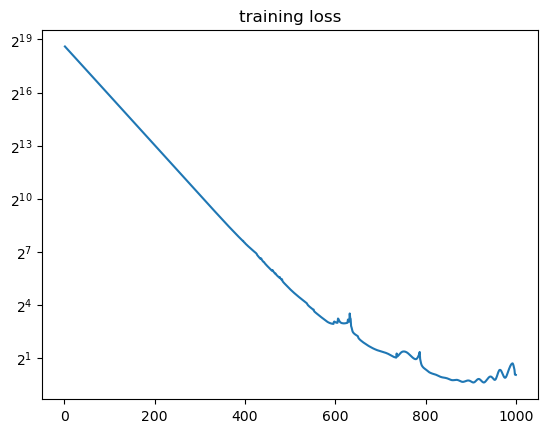

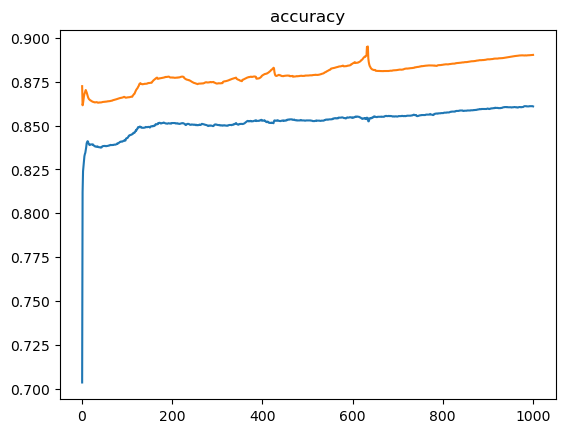

In [16]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.yscale('log',base=2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')